In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
import csv

import sys

import argparse 
import torch.serialization 

In [2]:
sys.path.append('/kaggle/input/openfwi-pretrainedmodel/OpenFWI')


try:
    from network import InversionNet, replace_legacy
    OPENFWI_AVAILABLE = True
    print("Successfully imported InversionNet and replace_legacy from OpenFWI.network.")
except ImportError:
    print("Warning: OpenFWI.network could not be imported. InversionNet and related functions will not be available.")
    InversionNet = None
    replace_legacy = None
    OPENFWI_AVAILABLE = False

Successfully imported InversionNet and replace_legacy from OpenFWI.network.


In [3]:

MODEL_CLASSES = [
    "InversionNet",
    "DumbNet",
]

PATHS = [
    "/kaggle/input/gwi-pretrainedmodel/PretrainedModel/ffb_l2.pth",
    "/kaggle/input/dumbernet/pytorch/default/1/model_84.pth"
    ]

PATH_WEIGHTS = [
    0.5,
    0.5
    ]

assert len(PATHS) == len(PATH_WEIGHTS), "The number of model paths does not match the number of weights."

total_weight = sum(PATH_WEIGHTS)
PATH_WEIGHTS = [w / total_weight for w in PATH_WEIGHTS]

## Find files to load and create Dataset

In [4]:
all_inputs = [
    f
    for f in
    Path('/kaggle/input/waveform-inversion/train_samples').rglob('*.npy')
    if ('seis' in f.stem) or ('data' in f.stem)
]

In [5]:
def inputs_files_to_output_files(input_files):
    return [
        Path(str(f).replace('seis', 'vel').replace('data', 'model'))
        for f in input_files
    ]

all_outputs = inputs_files_to_output_files(all_inputs)

In [6]:
assert all(f.exists() for f in all_outputs)

In [7]:
existing_inputs = [f for f, o in zip(all_inputs, all_outputs) if o.exists()]
existing_outputs = [o for f, o in zip(all_inputs, all_outputs) if o.exists()]

if not existing_inputs:
     raise FileNotFoundError("No valid training data pairs found.")


train_indices = range(0, len(existing_inputs), 2)
train_inputs = [existing_inputs[i] for i in train_indices]
train_outputs = [existing_outputs[i] for i in train_indices]

valid_inputs = [f for i, f in enumerate(existing_inputs) if i not in train_indices]
valid_outputs = [o for i, o in enumerate(existing_outputs) if i not in train_indices]

In [8]:
class SeismicDataset(Dataset):
    def __init__(self, inputs_files, output_files, n_examples_per_file=500):
        assert len(inputs_files) == len(output_files)
        self.inputs_files = inputs_files
        self.output_files = output_files
        self.n_examples_per_file = n_examples_per_file

    def __len__(self):
        return len(self.inputs_files) * self.n_examples_per_file

    def __getitem__(self, idx):
        # Calculate file offset and sample offset within file
        file_idx = idx // self.n_examples_per_file
        sample_idx = idx % self.n_examples_per_file

        X = np.load(self.inputs_files[file_idx], mmap_mode='r')
        y = np.load(self.output_files[file_idx], mmap_mode='r')

        try:
            return X[sample_idx].copy(), y[sample_idx].copy()
        finally:
            del X, y

In [9]:
num_workers = 4


def collate_fn(batch):
    batch = list(filter(lambda x: x is not None and x[0] is not None, batch))
    if not batch:
        return None # Or handle empty batch case
    return torch.utils.data.dataloader.default_collate(batch)


if train_inputs:
    dstrain = SeismicDataset(train_inputs, train_outputs)
    dltrain = DataLoader(dstrain, batch_size=128, shuffle=True, pin_memory=True, drop_last=True, num_workers=num_workers, persistent_workers=num_workers > 0)

if valid_inputs:
    dsvalid = SeismicDataset(valid_inputs, valid_outputs)
    dlvalid = DataLoader(dsvalid, batch_size=128, shuffle=False, pin_memory=True, drop_last=False, num_workers=num_workers, persistent_workers=num_workers > 0)



## DumbNet

from [DumberNet-SUB, PUN](https://www.kaggle.com/code/pshikk/dumbernet-sub)

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super().__init__()
        stride = 2 if downsample else 1

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = None
        if downsample or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(identity)

        out += identity
        return self.relu(out)

class DumbNet(nn.Module):
    '''Deep CNN with residual blocks and dense classifier'''
    def __init__(self, input_channels=5, output_size=70 * 70):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # 1000x70 -> ~250x18
        )

        self.layer1 = ResidualBlock(64, 128, downsample=True)  # ~125x9
        self.layer2 = ResidualBlock(128, 256, downsample=True)  # ~63x5
        self.layer3 = ResidualBlock(256, 512, downsample=True)  # ~32x3
        self.layer4 = ResidualBlock(512, 1024, downsample=True)
        self.layer5 = ResidualBlock(1024, 1024, downsample = False)# same spatial

        self.global_pool = nn.AdaptiveAvgPool2d((4, 4))  # fixed output

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * 4 * 4, 2048),
            nn.GELU(),
            nn.Dropout(0.5),

            nn.Linear(2048, 1024),
            nn.GELU(),
            nn.Dropout(0.25),

            nn.Linear(1024, output_size)
        )

    def forward(self, x):
        bs = x.size(0)

        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.global_pool(x)

        x = self.classifier(x)
        # Ensure the output is reshaped correctly and scaled
        # Adding a small epsilon for stability if needed, but typically not required here
        return x.view(bs, 1, 70, 70) * 1000.0 + 1500.0


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [12]:
model_zoo = {"DumbNet": DumbNet}
if OPENFWI_AVAILABLE:
    model_zoo["InversionNet"] = InversionNet

In [13]:
models = []
model_class_names_loaded = [] 

try:
    if argparse.Namespace not in torch.serialization.get_safe_globals():
         torch.serialization.add_safe_globals([argparse.Namespace])
         print("argparse.Namespace added to safe globals for torch.load.")
    else:
         print("argparse.Namespace is already in safe globals.")
except AttributeError:
    print("Warning: torch.serialization.add_safe_globals not found or failed.")

for i, (path, model_cls_name) in enumerate(zip(PATHS, MODEL_CLASSES)):
    print(f"\n--- Loading model {i+1}/{len(PATHS)} ---")
    print(f"  Class: '{model_cls_name}'")
    print(f"  Path:  '{path}'")

    if model_cls_name not in model_zoo:
         print(f"Warning: Model class '{model_cls_name}' not found in model_zoo. Skipping.")
         continue

    ModelClass = model_zoo[model_cls_name]
    try:
        model = ModelClass().to(device)
        print(f"  Instantiated model {model_cls_name}.")
    except Exception as e:
        print(f"Error: Failed to instantiate model class '{model_cls_name}': {e}. Skipping.")
        continue

    state_dict = None
    load_success = False
    e_true = None 

    try:
        print(f"  Attempting to load state_dict with weights_only=True...")
        loaded_object_true = torch.load(path, map_location=device, weights_only=True)

        if isinstance(loaded_object_true, dict):
            print("  Object loaded with weights_only=True is a dict.")
            is_checkpoint_dict = ('model' in loaded_object_true or
                                  'optimizer' in loaded_object_true or
                                  'state_dict' in loaded_object_true or
                                  'state_dict_G' in loaded_object_true)

            if is_checkpoint_dict:
                print("  Detected checkpoint structure. Extracting state_dict...")
                if 'model' in loaded_object_true and isinstance(loaded_object_true['model'], dict):
                    state_dict = loaded_object_true['model']
                    print("  Extracted state_dict from 'model' key.")
                elif 'state_dict_G' in loaded_object_true and isinstance(loaded_object_true['state_dict_G'], dict) and model_cls_name == "InversionNet":
                     state_dict = loaded_object_true['state_dict_G']
                     print("  Extracted state_dict from 'state_dict_G' key.")
                elif 'state_dict' in loaded_object_true and isinstance(loaded_object_true['state_dict'], dict):
                    state_dict = loaded_object_true['state_dict']
                    print("  Extracted state_dict from 'state_dict' key.")
                else:
                    print("Error: Checkpoint structure detected, but could not find standard state_dict keys ('model', 'state_dict', 'state_dict_G').")
                    state_dict = None 
            else:
                print("  Assuming loaded dict is the state_dict directly.")
                state_dict = loaded_object_true

            if isinstance(state_dict, dict): 
                if model_cls_name == "InversionNet" and replace_legacy:
                    try:
                        print("  Applying replace_legacy...")
                        state_dict = replace_legacy(state_dict)
                        print("  replace_legacy applied.")
                    except Exception as legacy_err:
                        print(f"Warning: Error applying replace_legacy: {legacy_err}")

                model.load_state_dict(state_dict)
                print("  Successfully applied state_dict to model (weights_only=True path).")
                load_success = True
            else:
                 print("Error: Failed to extract/identify a valid state_dict (dictionary).")
                 load_success = False

        else:
             print(f"Error: Loaded object with weights_only=True is not a dictionary (type: {type(loaded_object_true)}). Cannot load.")

    except RuntimeError as err_true:
        e_true = err_true
        print(f"Warning: Failed during weights_only=True path. Error: {e_true}")
        if "Unsupported global" not in str(e_true) and "WeightsUnpickler" not in str(e_true):
            print("  Error did not seem related to unsupported types. Fallback might not help.")
    except FileNotFoundError:
        print(f"Error: Model file not found at {path}. Skipping.")
        continue
    except Exception as e_other_true:
        print(f"Error: An unexpected error occurred during weights_only=True load/processing: {e_other_true}. Skipping.")
        continue


    should_fallback = (
        not load_success and
        e_true is not None and
        ("Unsupported global" in str(e_true) or "WeightsUnpickler" in str(e_true))
    )
    if should_fallback:
        print("\n  Attempting fallback: Loading with weights_only=False...")
        print("  >>> Warning: This can execute arbitrary code if the file is from an untrusted source! <<<")
        try:
            loaded_object_false = torch.load(path, map_location=device, weights_only=False)
            print(f"  Loaded object type with weights_only=False: {type(loaded_object_false)}")
            if isinstance(loaded_object_false, dict):
                if 'model' in loaded_object_false:
                    print("  Found 'model' key. Extracting state_dict from checkpoint['model']...")
                    state_dict = loaded_object_false['model']
                elif 'state_dict_G' in loaded_object_false and model_cls_name == "InversionNet":
                    print("  Found 'state_dict_G' key. Extracting...")
                    state_dict = loaded_object_false['state_dict_G']
                elif 'state_dict' in loaded_object_false:
                    print("  Found 'state_dict' key. Extracting...")
                    state_dict = loaded_object_false['state_dict']
                else:
                    print("  No standard keys found. Assuming loaded dict is the state_dict.")
                    state_dict = loaded_object_false
            elif isinstance(loaded_object_false, nn.Module):
                 print("Warning: Loaded object is an nn.Module. Extracting state_dict from it.")
                 state_dict = loaded_object_false.state_dict()
            else:
                print(f"Error: Loaded object with weights_only=False is not a dictionary or nn.Module (type: {type(loaded_object_false)}).")
                state_dict = None

            if isinstance(state_dict, dict):
                 print("  Successfully extracted/identified state_dict.")
                 if model_cls_name == "InversionNet" and replace_legacy:
                     try:
                         print("  Applying replace_legacy...")
                         state_dict = replace_legacy(state_dict)
                         print("  replace_legacy applied.")
                     except Exception as legacy_err:
                         print(f"Warning: Error applying replace_legacy: {legacy_err}")
                 model.load_state_dict(state_dict)
                 print("  Successfully applied state_dict to model (using weights_only=False fallback).")
                 load_success = True
            elif state_dict is not None:
                 print(f"Error: Extracted state_dict is not a dictionary (type: {type(state_dict)}). Load failed.")

        except Exception as e_false:
            print(f"Error: Failed during weights_only=False fallback processing. Error: {e_false}. Skipping this model.")
            load_success = False

    if load_success:
        model.eval()
        models.append(model)
        model_class_names_loaded.append(model_cls_name)
        print(f"--- Successfully loaded and prepared model {i+1} ({model_cls_name}) ---")
    else:
        print(f"--- Failed to load model {i+1} ({model_cls_name}) ---")


# --- Post-loading checks and weight filtering ---
if not models:
    raise RuntimeError("No models could be loaded successfully. Please check logs for errors.")
original_indices = [i for i, cls_name in enumerate(MODEL_CLASSES) if cls_name in model_class_names_loaded]
filtered_weights = [PATH_WEIGHTS[i] for i in original_indices]
total_weight = sum(filtered_weights)
if total_weight > 0:
     PATH_WEIGHTS_USED = [w / total_weight for w in filtered_weights]
else:
     if models:
         PATH_WEIGHTS_USED = [1.0 / len(models)] * len(models)
     else:
          PATH_WEIGHTS_USED = []
print(f"\nSuccessfully loaded {len(models)} models in total.")
print(f"Models loaded: {model_class_names_loaded}")
print(f"Weights used (normalized): {PATH_WEIGHTS_USED}")

argparse.Namespace added to safe globals for torch.load.

--- Loading model 1/2 ---
  Class: 'InversionNet'
  Path:  '/kaggle/input/gwi-pretrainedmodel/PretrainedModel/ffb_l2.pth'
  Instantiated model InversionNet.
  Attempting to load state_dict with weights_only=True...
  Object loaded with weights_only=True is a dict.
  Detected checkpoint structure. Extracting state_dict...
  Extracted state_dict from 'model' key.
  Applying replace_legacy...
  replace_legacy applied.
  Successfully applied state_dict to model (weights_only=True path).
--- Successfully loaded and prepared model 1 (InversionNet) ---

--- Loading model 2/2 ---
  Class: 'DumbNet'
  Path:  '/kaggle/input/dumbernet/pytorch/default/1/model_84.pth'
  Instantiated model DumbNet.
  Attempting to load state_dict with weights_only=True...
  Object loaded with weights_only=True is a dict.
  Assuming loaded dict is the state_dict directly.
  Successfully applied state_dict to model (weights_only=True path).
--- Successfully loa

## Inference and Submission

Found 65818 test files.
Starting prediction loop. Output will be saved to submission.csv


test:   0%|          | 0/515 [00:00<?, ?it/s]

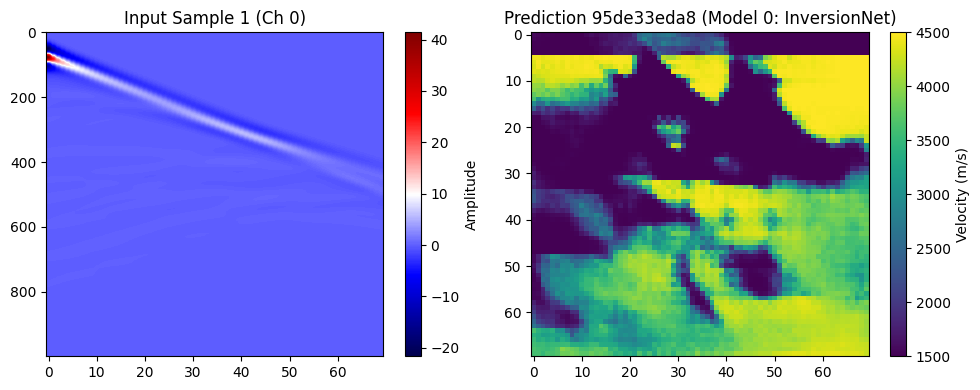

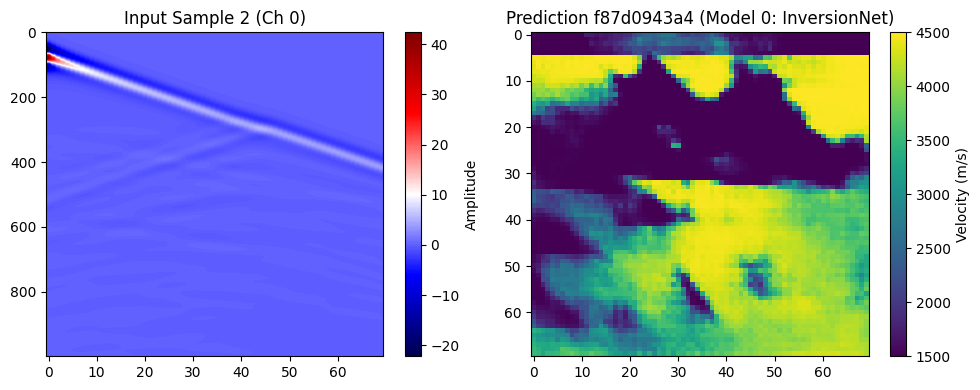

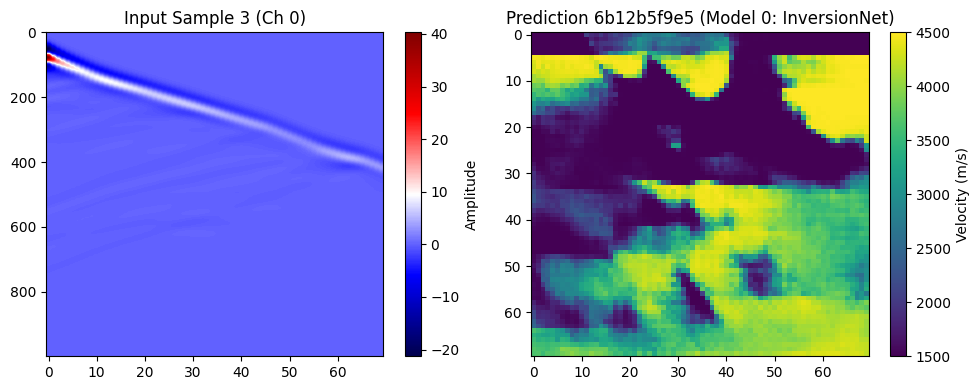

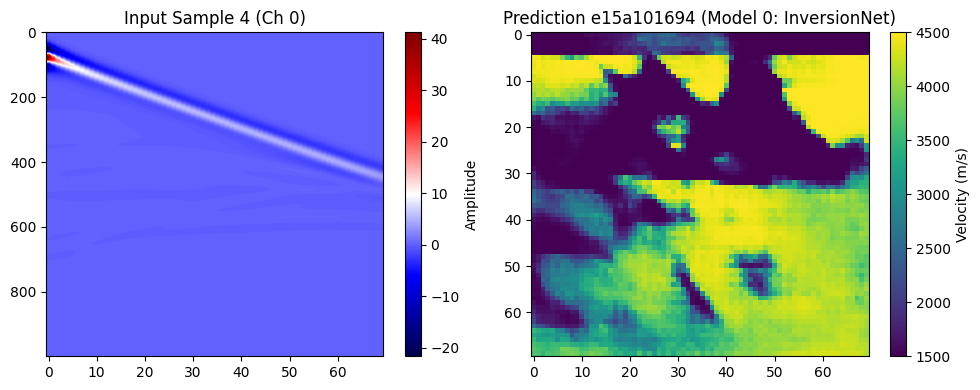

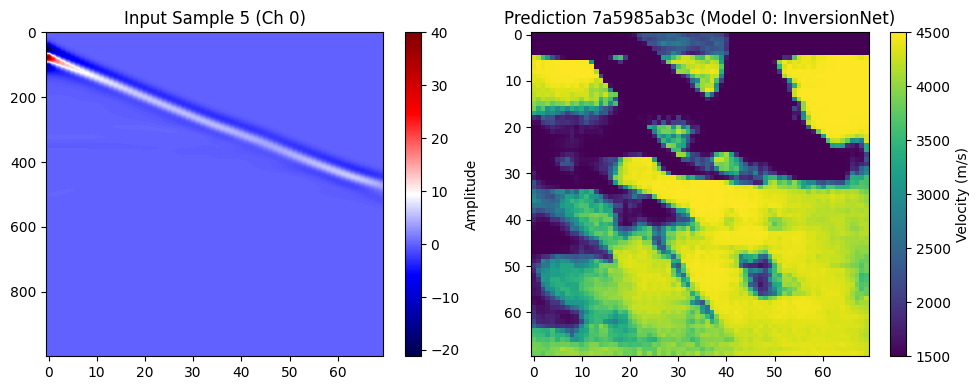

Prediction finished. Submission file saved to submission.csv
Displayed predictions for the first 5 samples using the first loaded model (InversionNet).
Script finished.


In [14]:
test_dir = Path('/kaggle/input/waveform-inversion/test')
if test_dir.exists():
    test_files = list(test_dir.glob('*.npy'))
else:
    print(f"Warning: Test directory not found: {test_dir}")
    test_files = [] # No test files to process

if not test_files:
    print("No test files found. Skipping prediction and submission.")
else:
    print(f"Found {len(test_files)} test files.")

    x_cols = [f'x_{i}' for i in range(1, 70, 2)]
    fieldnames = ['oid_ypos'] + x_cols

    class TestDataset(Dataset):
        def __init__(self, test_files):
            self.test_files = test_files

        def __len__(self):
            return len(self.test_files)

        def __getitem__(self, i):
            test_file = self.test_files[i]
            if not test_file.exists():
                raise FileNotFoundError(f"Test file not found: {test_file}")

            try:
                data = np.load(test_file)
                return data.astype(np.float32), test_file.stem
            except Exception as e:
                print(f"Error loading test file {test_file}: {e}")
                raise


    if test_files: 
        ds_test = TestDataset(test_files)
        dl_test = DataLoader(ds_test, batch_size=128, num_workers=num_workers, pin_memory=True)


        output_filename = 'submission.csv'
        print(f"Starting prediction loop. Output will be saved to {output_filename}")
        plot_counter = 0
        MAX_PLOTS = 5
        VEL_MIN = 1500.0
        VEL_MAX = 4500.0 

        with open(output_filename, 'wt', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()

            if 'dl_test' in locals() and dl_test is not None:
                for batch_data in tqdm(dl_test, desc='test'):
                    if batch_data is None: continue
                    inputs, oids_test = batch_data
                    if inputs is None or not len(inputs): continue

                    inputs = inputs.to(device)

                    # Initialize ensemble outputs tensor
                    ensemble_outputs = None

                    with torch.inference_mode():
                        outputs_first_model_scaled = None # Store first model's SCALED output for plotting

                        for i, (model, weight, model_cls_name) in enumerate(zip(models, PATH_WEIGHTS_USED, model_class_names_loaded)):
                            try:
                                outputs_raw = model(inputs)

                                if model_cls_name == "DumbNet":
                                    outputs_scaled = outputs_raw
                                elif model_cls_name == "InversionNet":
                                    outputs_scaled = (outputs_raw + 1.0) / 2.0 * (VEL_MAX - VEL_MIN) + VEL_MIN
                                else:
                                    print(f"Warning: Unknown post-processing for model type {model_cls_name}. Using raw output.")
                                    outputs_scaled = outputs_raw


                                if i == 0:
                                    ensemble_outputs = torch.zeros_like(outputs_scaled, device=device)
                                    outputs_first_model_scaled = outputs_scaled.detach().clone()

                                ensemble_outputs += outputs_scaled * weight

                            except Exception as e:
                                print(f"Error during inference or post-processing with model {i} (Class: {model_cls_name}, Path: {PATHS[i]}): {e}")
                                if i == 0 and ensemble_outputs is None:
                                     try:
                                         ref_shape = (inputs.shape[0], 1, 70, 70)
                                         ensemble_outputs = torch.zeros(ref_shape, device=device)
                                         print("Warning: First model failed, initialized ensemble tensor with estimated shape.")
                                     except Exception:
                                          print("Error: Cannot determine output shape. Skipping batch.")
                                          ensemble_outputs = None
                                          break
                                continue 

                    if ensemble_outputs is None:
                        print("Skipping batch due to errors in ensemble calculation.")
                        continue

                    y_preds = ensemble_outputs[:, 0].cpu().numpy() # Assuming channel dim is 1


                    # --- Plot (First Model Only) ---
                    if plot_counter < MAX_PLOTS and outputs_first_model_scaled is not None:
                        num_to_plot = min(MAX_PLOTS - plot_counter, len(oids_test))
                        y_preds_first_model_cpu = outputs_first_model_scaled[:, 0].cpu().numpy()

                        for i in range(num_to_plot):
                            if plot_counter >= MAX_PLOTS: break

                            plt.figure(figsize=(10, 4))
                            # Plot input
                            plt.subplot(1, 2, 1)
                            try:
                                input_to_plot = inputs[i, 0].cpu().numpy()
                                plt.imshow(input_to_plot, cmap='seismic', aspect='auto')
                                plt.title(f"Input Sample {plot_counter + 1} (Ch 0)")
                                plt.colorbar(label='Amplitude')
                            except IndexError:
                                print(f"Warning: Could not plot input for index {i}.")
                                plt.title(f"Input Sample {plot_counter + 1} (Error)")
                            # Plot prediction (from first model, scaled)
                            plt.subplot(1, 2, 2)
                            try:
                                pred_to_plot = y_preds_first_model_cpu[i]
                                im = plt.imshow(pred_to_plot, cmap='viridis', aspect='auto', vmin=VEL_MIN, vmax=VEL_MAX) # Use velocity range for colorbar
                                plt.title(f"Prediction {oids_test[i]} (Model 0: {model_class_names_loaded[0]})") # Show model class
                                plt.colorbar(im, label='Velocity (m/s)')
                            except IndexError:
                                print(f"Warning: Could not plot prediction for index {i}.")
                                plt.title(f"Prediction {oids_test[i]} (Error)")

                            plt.tight_layout()
                            plt.show()
                            plot_counter += 1


                    if 'y_preds' in locals() and y_preds is not None:
                        for y_pred, oid_test in zip(y_preds, oids_test):
                            for y_pos in range(70):
                                try:
                                    row = dict(
                                        zip(
                                            x_cols,
                                            [np.nan_to_num(y_pred[y_pos, x_pos]) for x_pos in range(1, 70, 2)]
                                        )
                                    )
                                    row['oid_ypos'] = f"{oid_test}_y_{y_pos}"
                                    writer.writerow(row)
                                except IndexError:
                                    print(f"Warning: Index error during CSV writing for oid {oid_test}, y_pos {y_pos}. Skipping row.")
                                    continue

        print(f"Prediction finished. Submission file saved to {output_filename}")
        if plot_counter > 0:
            print(f"Displayed predictions for the first {plot_counter} samples using the first loaded model ({model_class_names_loaded[0]}).")

    else:
        print("No test files found or DataLoader could not be created, skipping prediction loop.")

# Optional: Clean up
# del models, ds_test, dl_test, dstrain, dltrain, dsvalid, dlvalid
# torch.cuda.empty_cache()

print("Script finished.")